<a href="https://colab.research.google.com/github/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/blob/main/Drivers_Behavior_Detection_with_Smartphone_Signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Driver Behavior Detection with Smartphone Signal Processing

## Project Architecture

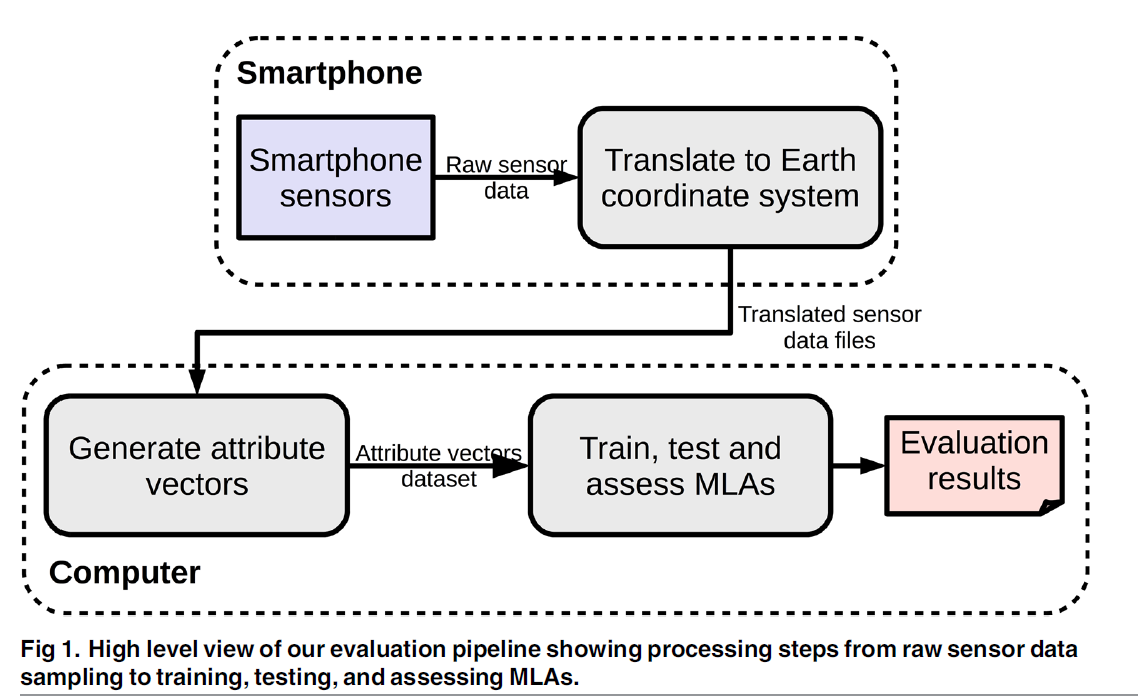

# Loading Data

Source:
- https://data.mendeley.com/datasets/5stn873wft/1
- S. Nazirkar, “Phone sensor data while driving a car and normal or aggressive driving behaviour classification”. Mendeley, 2021. doi: 10.17632/5STN873WFT.1.

Data has been recorded on an android phone attached to the dashboard of the car. Data was collected while driving the car on city roads in mild traffic.
The parameters recorded are:
- Longitude
- Latitude
- Speed
- Distance
- Time
- Accelerometer X
- Accelerometer Y
- Accelerometer Z
- Heading
- Gyroscope X
- Gyroscope Y
- Gyroscope Z

Sampling Rate: Average 2 samples (rows) per second

Driver Behaviors:
    1. Normal driving (Class Label: 0)
    2. Aggressive driving (Class Label: 1)

In [1]:
# general libraries
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid", rc={ 'figure.figsize': (11, 4)})
import numpy as np
import random
from sklearn.utils import check_random_state  # Used to manage a random_state object
# Set a seed value
seed_value = 42
np.random.seed(42) # Set `numpy` seed
random.seed(42) # Set `random` seed
random_state = check_random_state(42) # Set `sklearn` seed via the random_state parameter in sklearn functions/models
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
import joblib
import time
import os


In [2]:
!pip install pyTelegramBotAPI

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 3.9 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
import telebot
chat_id = userdata.get('CHAT_ID')
bot_id = userdata.get('BOTTOKEN')
bot = telebot.TeleBot(bot_id)


In [4]:
path1 = 'https://raw.githubusercontent.com/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/main/data/nazirkar_2021_dataset/1_20210317_184512.csv'
path2= 'https://raw.githubusercontent.com/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/main/data/nazirkar_2021_dataset/2_20210317_171452.csv'
path3= 'https://raw.githubusercontent.com/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/main/data/nazirkar_2021_dataset/3_FinalDatasetCsv.csv'
df1=pd.read_csv(path1)
df1['data_set'] = 1
# df1.info()
df2=pd.read_csv(path2)
# df2.info()
df2['data_set'] = 2
df3=pd.read_csv(path3)
# df3.info()
df3['data_set'] = 3

df_combined = pd.concat([df2,df1])
df_combined.info()
df_combined.head()


<class 'pandas.core.frame.DataFrame'>
Index: 14249 entries, 0 to 6645
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  14249 non-null  float64
 1   Latitude   14249 non-null  float64
 2   Speed      14249 non-null  float64
 3   Distance   14249 non-null  float64
 4   Time       14249 non-null  object 
 5   Acc X      14249 non-null  float64
 6   Acc Y      14249 non-null  float64
 7   Acc Z      14249 non-null  float64
 8   Heading    14249 non-null  float64
 9   gyro_x     14249 non-null  float64
 10  gyro_y     14249 non-null  float64
 11  gyro_z     14249 non-null  float64
 12  data_set   14249 non-null  int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 1.5+ MB


Longitude   Latitude  Speed      Distance      Time     Acc X     Acc Y  \
0  73.831324  18.518700   1.29  8.312031e+06  17-14-53  0.046402 -0.137178   
1  73.831324  18.518700   1.29  8.312031e+06  17-14-53 -0.136978  0.365242   
2  73.831324  18.518700   1.29  8.312031e+06  17-14-53 -0.045355 -0.103340   
3  73.831201  18.518714   0.31  1.302423e+01  17-14-53  0.242089  0.072761   
4  73.831201  18.518714   0.31  1.302423e+01  17-14-53 -0.230234  0.011765   

      Acc Z  Heading    gyro_x    gyro_y    gyro_z  data_set  
0 -0.282934    265.0 -0.036306 -0.008226 -0.023416         2  
1  0.108889    266.0  0.035776 -0.009448  0.009570         2  
2 -0.534985    266.0 -0.011871 -0.027774  0.003462         2  
3 -0.350396    266.0 -0.017980  0.002769 -0.005091         2  
4 -0.494085    266.0  0.011342  0.003380  0.006516         2

In [5]:
# prompt: merge left df_combined and df3 on  matching 'Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y' ,'gyro_z'
merged_df = pd.merge(left=df_combined, right=df3, on=['Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z'], how='left',
                     suffixes=('_origin', '_new'))
# merged_df.info()
merged_df.head(2)


Longitude  Latitude  Speed   Distance      Time     Acc X     Acc Y  \
0  73.831324   18.5187   1.29  8312031.0  17-14-53  0.046402 -0.137178   
1  73.831324   18.5187   1.29  8312031.0  17-14-53 -0.136978  0.365242   

      Acc Z  Heading    gyro_x    gyro_y    gyro_z  data_set_origin  label  \
0 -0.282934    265.0 -0.036306 -0.008226 -0.023416                2    0.0   
1  0.108889    266.0  0.035776 -0.009448  0.009570                2    0.0   

   data_set_new  
0           3.0  
1           3.0

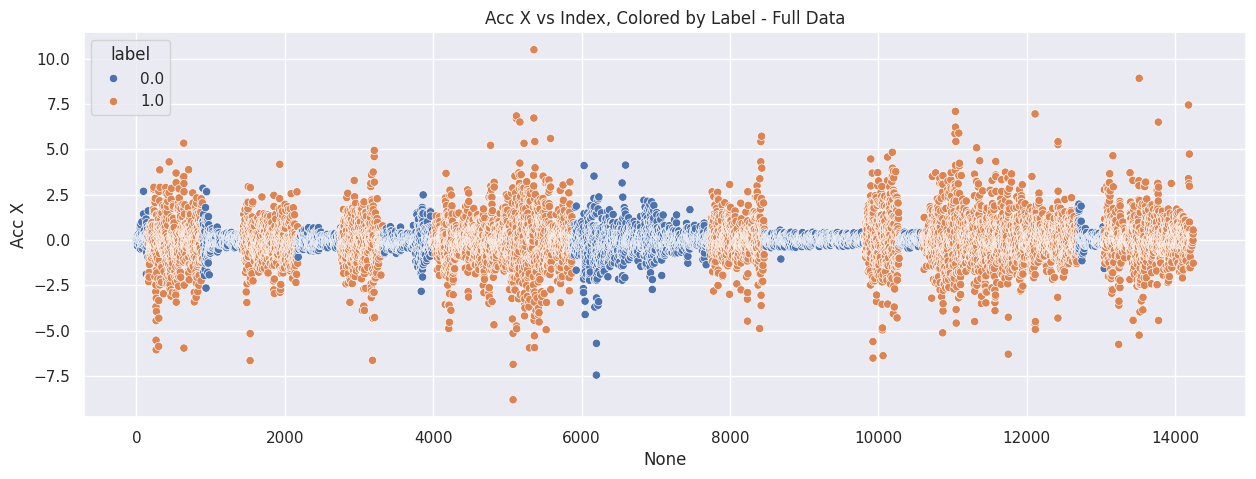

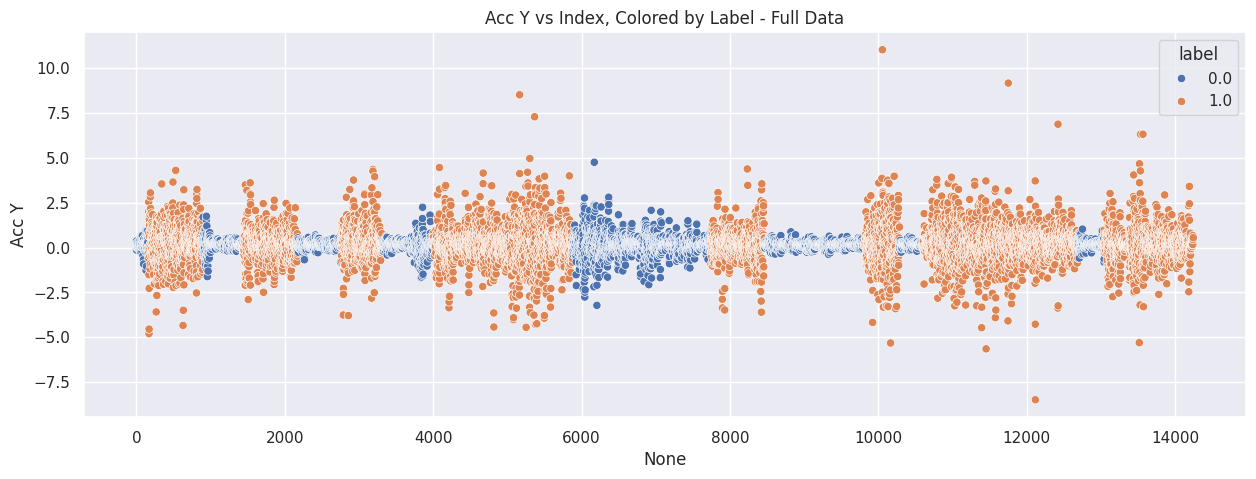

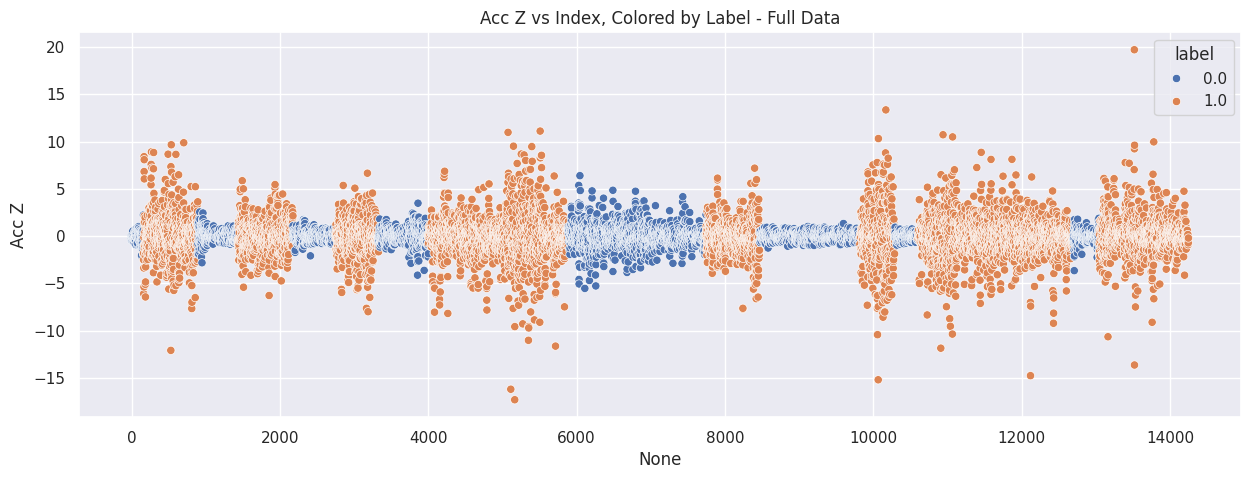

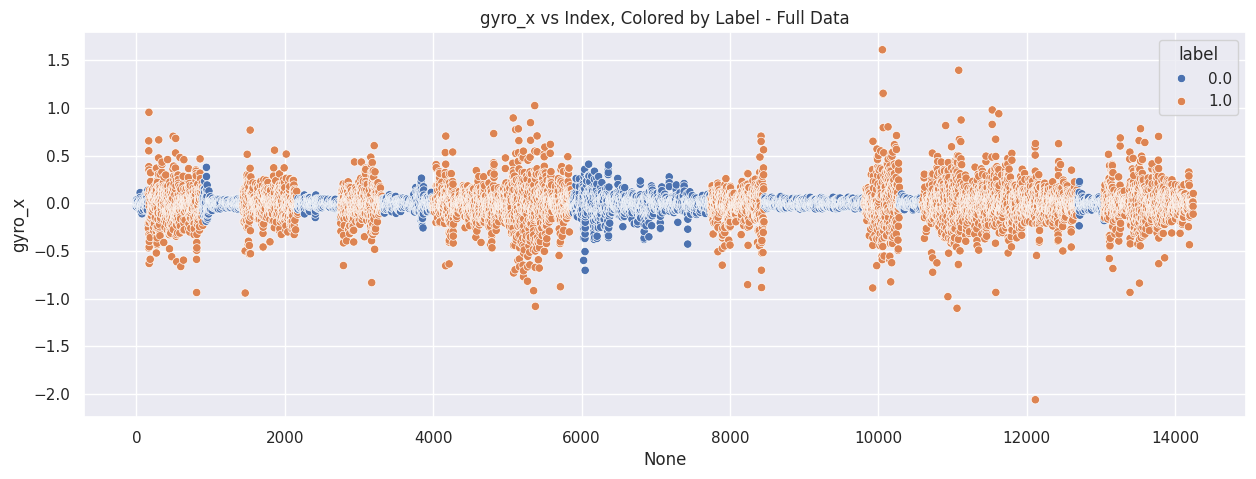

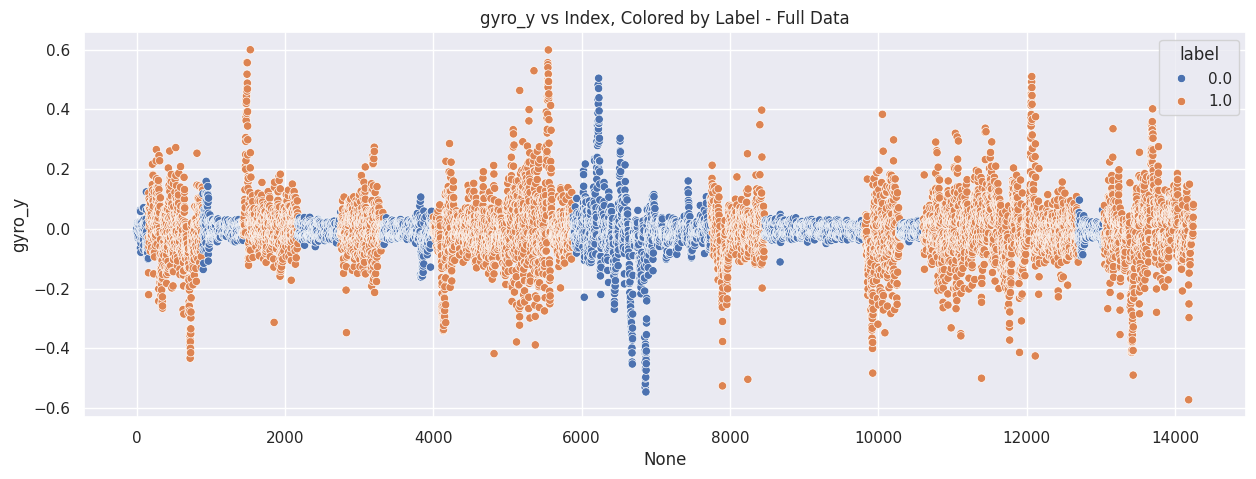

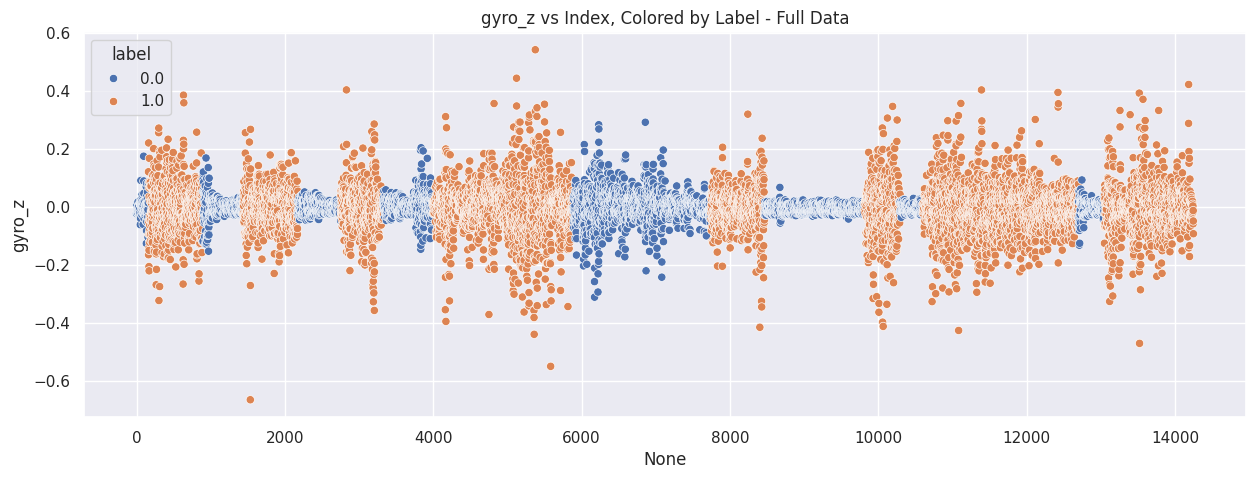

In [6]:
cols = ['Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z']
for col in cols:
  plt.figure(figsize=(15, 5))
  sns.scatterplot(data=merged_df, x=merged_df.index, y=col, hue='label')
  plt.title(f'{col} vs Index, Colored by Label - Full Data')
  plt.show()

CANCELEDWe decide to fill nan values with 0 and to consider 0 as "Not Aggressive", while 0 could mean anything else.

In [7]:
display(merged_df.tail(2))


Longitude   Latitude  Speed   Distance      Time     Acc X     Acc Y  \
14251  73.831196  18.518508    0.0  2074.5303  18-56-18 -0.436406 -0.219264   
14252  73.831196  18.518508    0.0  2074.5303  18-56-18 -0.436406 -0.219264   

          Acc Z  Heading    gyro_x    gyro_y    gyro_z  data_set_origin  \
14251  0.397958     85.0 -0.001609  0.024903  0.000876                1   
14252  0.397958     85.0 -0.001609  0.024903  0.000876                1   

       label  data_set_new  
14251    NaN           NaN  
14252    NaN           NaN

In [ ]:
# # prompt: using tmp plot label vs index
# import matplotlib.pyplot as plt
# sns.lineplot(data=merged_df, x=merged_df.index, y="Time")
# plt.title('Time vs Index')
# plt.show()


In [8]:
# fill nan values with 0
# merged_df.fillna(10, inplace=True)
merged_df.dropna(inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# change label to int type
merged_df['label'] = merged_df['label'].astype(int)
merged_df['Time'] = pd.to_datetime(merged_df['Time'], format='%H-%M-%S')
# merged_df.to_csv('Nazirkar_full.csv',index=False)
merged_df.info()
display(merged_df.head(2))
display(merged_df['label'].value_counts().to_frame())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10169 entries, 0 to 10168
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Longitude        10169 non-null  float64       
 1   Latitude         10169 non-null  float64       
 2   Speed            10169 non-null  float64       
 3   Distance         10169 non-null  float64       
 4   Time             10169 non-null  datetime64[ns]
 5   Acc X            10169 non-null  float64       
 6   Acc Y            10169 non-null  float64       
 7   Acc Z            10169 non-null  float64       
 8   Heading          10169 non-null  float64       
 9   gyro_x           10169 non-null  float64       
 10  gyro_y           10169 non-null  float64       
 11  gyro_z           10169 non-null  float64       
 12  data_set_origin  10169 non-null  int64         
 13  label            10169 non-null  int64         
 14  data_set_new     10169 non-null  float

Longitude  Latitude  Speed   Distance                Time     Acc X  \
0  73.831324   18.5187   1.29  8312031.0 1900-01-01 17:14:53  0.046402   
1  73.831324   18.5187   1.29  8312031.0 1900-01-01 17:14:53 -0.136978   

      Acc Y     Acc Z  Heading    gyro_x    gyro_y    gyro_z  data_set_origin  \
0 -0.137178 -0.282934    265.0 -0.036306 -0.008226 -0.023416                2   
1  0.365242  0.108889    266.0  0.035776 -0.009448  0.009570                2   

   label  data_set_new  
0      0           3.0  
1      0           3.0

count
label       
1       6869
0       3300

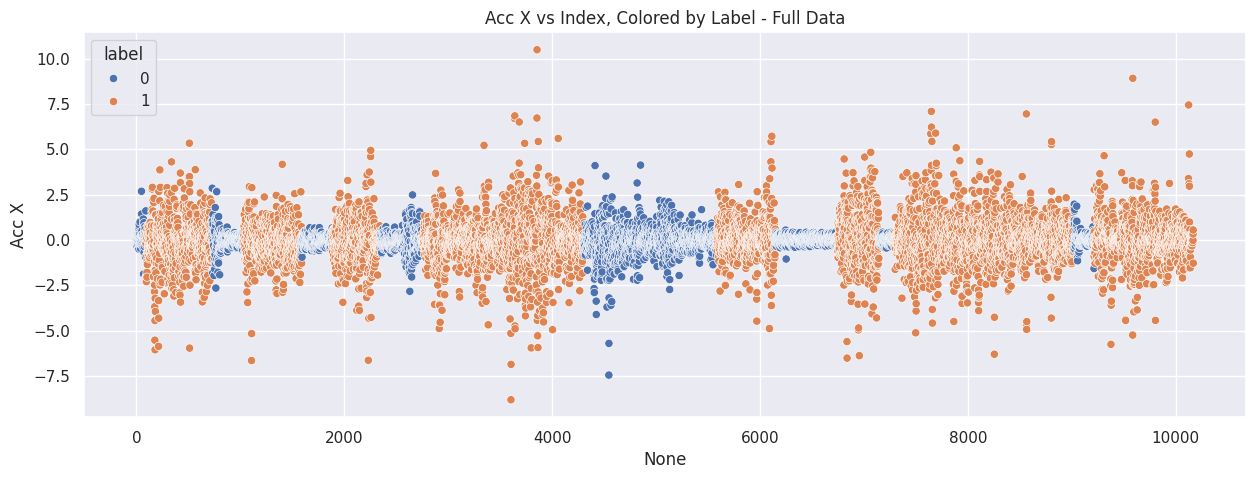

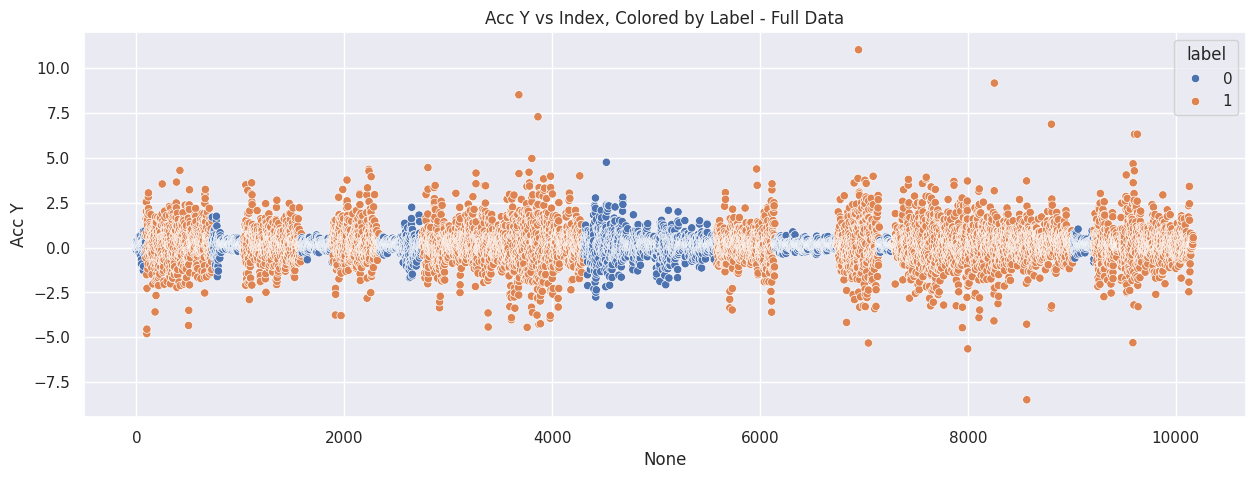

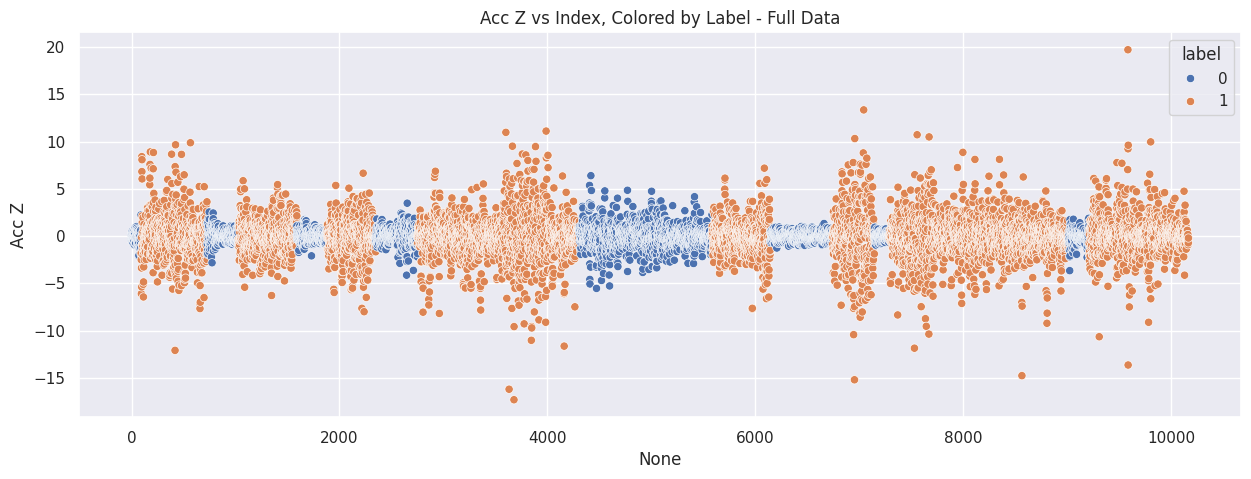

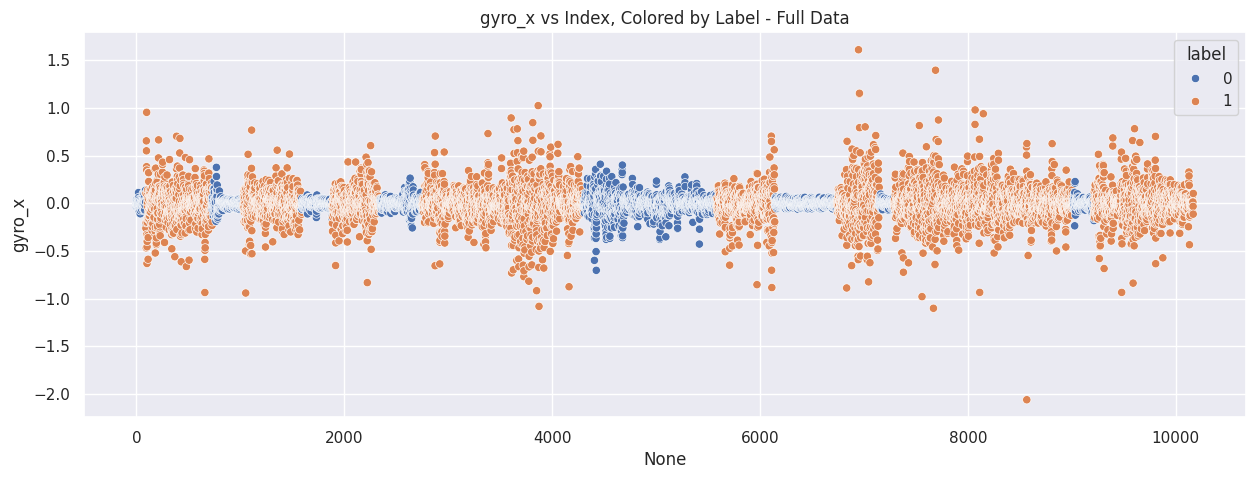

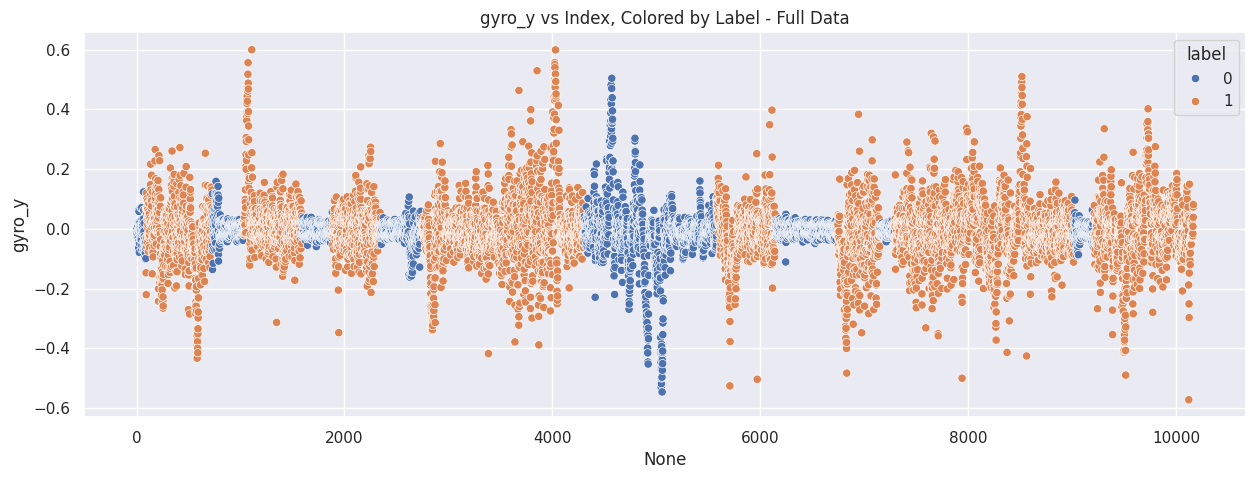

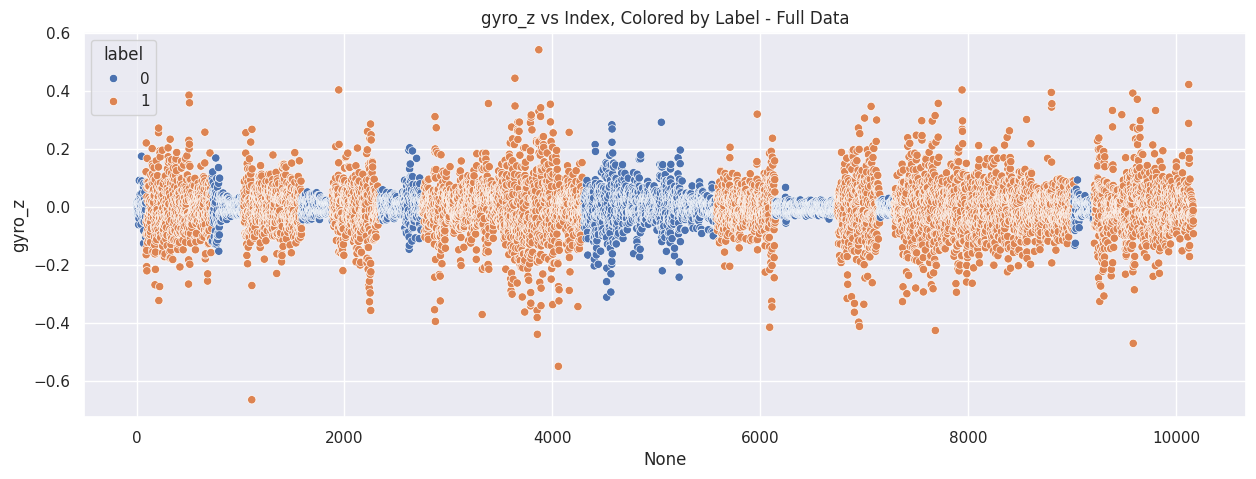

In [9]:
cols = ['Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z']
for col in cols:
  plt.figure(figsize=(15, 5))
  sns.scatterplot(data=merged_df, x=merged_df.index, y=col, hue='label')
  plt.title(f'{col} vs Index, Colored by Label - Full Data')
  plt.show()

In [ ]:
# # prompt: plot label vs Time between 17:00 to 17:35

# import matplotlib.pyplot as plt
# plt.plot(merged_df.loc[(merged_df['Time'] >= '1900-01-01 17:00:00') & (merged_df['Time'] <= '1900-01-01 17:40:00'), 'Time'],
#           merged_df.loc[(merged_df['Time'] >= '1900-01-01 17:00:00') & (merged_df['Time'] <= '1900-01-01 17:40:00'), 'label'])
# plt.ylabel('label')
# plt.xlabel('Time')
# plt.title('label vs Time between 17:00 to 17:40')
# plt.show()


In [ ]:
# # prompt: plot label vs Time between 17:00 to 17:35

# import matplotlib.pyplot as plt
# plt.plot(merged_df.loc[(merged_df['Time'] >= '1900-01-01 18:00:00') & (merged_df['Time'] <= '1900-01-01 19:00:00'), 'Time'],
#           merged_df.loc[(merged_df['Time'] >= '1900-01-01 18:00:00') & (merged_df['Time'] <= '1900-01-01 19:00:00'), 'label'])
# plt.ylabel('label')
# plt.xlabel('Time')
# plt.title('label vs Time between 17:00 to 17:40')
# plt.show()


In [ ]:
# prompt: using tmp plot label vs index

# import matplotlib.pyplot as plt
# sns.lineplot(data=merged_df, x=merged_df.index, y="label")
# plt.title('label vs Index')
# plt.show()


In [ ]:
# cols = ['Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z']
# for col in cols:
#   plt.figure(figsize=(15, 5))
#   sns.lineplot(data=train_df, x=train_df.index, y=col, hue='label')
#   plt.title(f'{col} vs Index, Colored by Label - TRAIN')
#   plt.show()

# Feature Extraction / Engineering

## Sliding Window for extracting features

In [10]:
import numpy as np
import pandas as pd

def compute_rolling_mode(labels, window_size):
    # Convert labels to a DataFrame for vectorized operations
    label_df = pd.DataFrame(labels)

    # Use cumulative sum for 0s and 1s to prepare for differential counting
    cumsum = label_df.cumsum()

    # The shifted cumulative sum gives us the start of the window counts
    shifted_cumsum = cumsum.shift(window_size)

    # The counts within the window are the differences
    window_counts = cumsum - shifted_cumsum.fillna(0)  # Fill NA for the first window

    # Determine the mode (most frequent value) across the window
    # 1 if the count of 1s is greater than half the window size, 0 otherwise
    mode_series = (window_counts >= window_size / 2).astype(int)['label']
    return mode_series

def sliding_window_features_optimized(data, min_t=2, max_t=15, step=1,sample_rate=2):
    sample_rate = sample_rate  # samples per second
    features = []
    numeric_columns = data.select_dtypes(include=[np.number])

    for t in range(min_t, max_t + 1):
        window_size = t * sample_rate
        rolling_windows = numeric_columns.rolling(window=window_size, min_periods=window_size)

        # Compute statistics for each window size
        max_values = rolling_windows.max()
        min_values = rolling_windows.min()
        std_values = rolling_windows.std()
        mean_values = rolling_windows.mean()

        # Calculate mean for first and second halves
        half_window = window_size // 2
        mu_acc_x_1 = numeric_columns['Acc X'].rolling(window=half_window, min_periods=half_window).mean()
        mu_acc_x_2 = numeric_columns['Acc X'].shift(-half_window).rolling(window=half_window, min_periods=half_window).mean()

        # Compute the mode of labels more efficiently
        label_mode = compute_rolling_mode(data['label'], window_size)

        for start in range(window_size - 1, len(data) - window_size + 1, step):
            feature_vector = {
                'time_duration': t,
                'range_acc_x': max_values['Acc X'].iloc[start] - min_values['Acc X'].iloc[start],
                'range_acc_y': max_values['Acc Y'].iloc[start] - min_values['Acc Y'].iloc[start],
                'sigma_acc_x': std_values['Acc X'].iloc[start],
                'sigma_acc_y': std_values['Acc Y'].iloc[start],
                'sigma_ori_x': std_values['gyro_x'].iloc[start],
                'sigma_ori_y': std_values['gyro_y'].iloc[start],
                'mu_acc_x': mean_values['Acc X'].iloc[start],
                'mu_acc_y': mean_values['Acc Y'].iloc[start],
                'mu_ori_x': mean_values['gyro_x'].iloc[start],
                'mu_ori_y': mean_values['gyro_y'].iloc[start],
                'mu_acc_x_1': mu_acc_x_1.iloc[start] if start < len(mu_acc_x_1) else None,
                'mu_acc_x_2': mu_acc_x_2.iloc[start] if start < len(mu_acc_x_2) else None,
                'maxori_x': max_values['gyro_x'].iloc[start],
                'maxori_y': max_values['gyro_y'].iloc[start],
                'minacc_y': min_values['Acc Y'].iloc[start],
                'label': label_mode.iloc[start] if start < len(label_mode) else None,
            }
            features.append(feature_vector)

    return pd.DataFrame(features)

data_processed = sliding_window_features_optimized(merged_df, min_t=2, max_t=10, step=1)



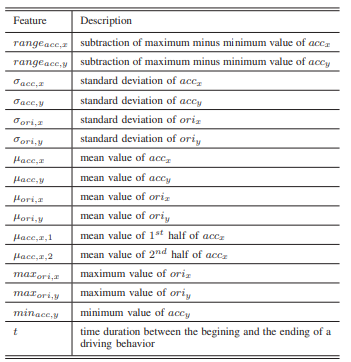

In [11]:
# @title
# import pandas as pd

# # Assuming 'df' is your main DataFrame
# def train_test_split_custom(df, chunk_size=20):
#   # Splitting df by 'data_set_origin' into a dictionary of DataFrames
#   grouped_data = {key: value for key, value in df.groupby('data_set_origin')}

#   # To store the training and testing DataFrames
#   train_dfs = []
#   test_dfs = []

#   # Processing each group
#   for key, group in grouped_data.items():
#       # Splitting each group into chunks of 20 rows
#       chunks = [group.iloc[i:i + chunk_size] for i in range(0, len(group), chunk_size)]

#       # Separating odd and even indexed chunks
#       train_chunks = [chunk for i, chunk in enumerate(chunks) if i % 2 == 0]  # odd index in 0-based index system
#       test_chunks = [chunk for i, chunk in enumerate(chunks) if i % 2 != 0]  # even index in 0-based index system

#       # Concatenating the chunks to form the full training and testing DataFrames for this group
#       if train_chunks:  # Checking if the list is not empty
#           train_dfs.append(pd.concat(train_chunks, ignore_index=True))
#       if test_chunks:
#           test_dfs.append(pd.concat(test_chunks, ignore_index=True))

#   # Finally, concatenating all training and testing DataFrames across all groups
#   raw_train = pd.concat(train_dfs, ignore_index=True) if train_dfs else pd.DataFrame()
#   raw_test = pd.concat(test_dfs, ignore_index=True) if test_dfs else pd.DataFrame()
#   return raw_train, raw_test

# Train / Test Split (for Time Series)

In [13]:
# prompt: sklearn train_test_split
data_processed = sliding_window_features_optimized(merged_df, min_t=2, max_t=7, step=1)

from sklearn.model_selection import train_test_split
X = data_processed.drop('label', axis=1)
y = data_processed['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, shuffle=True)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print("y_train value_counts", y_train.value_counts(normalize=True))
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
# data_processed
print("y_test value_counts", y_test.value_counts(normalize=True))

from sklearn.preprocessing import StandardScaler
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train shape: (48734, 16)
y_train shape: (48734,)
y_train value_counts label
1    0.677145
0    0.322855
Name: proportion, dtype: float64
X_test shape: (12184, 16)
y_test shape: (12184,)
y_test value_counts label
1    0.671947
0    0.328053
Name: proportion, dtype: float64


In [ ]:
# @title
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(# default values:
#                   n_splits=2,gap=0, max_train_size=None, test_size=None
#           )
# # for i, (train_index, test_index) in enumerate(tscv.split(merged_df)):
# #     print(f"Fold {i}:")
# #     print("  Train indices:", train_index)
# #     print("  Test indices:", test_index)
# # splitting

# # Create a column in merged_df to store the set allocation (train or test)
# # merged_df['Set'] = 'train'  # Default to 'train'

# required_columns =  [ 'Time', 'Acc X', 'Acc Y','Acc Z', 'gyro_x', 'gyro_y', 'gyro_z', 'label']
# for train_index, test_index in tscv.split(merged_df[merged_df['data_set_origin']==1]):
#     raw_train_1, raw_test_1 = merged_df[merged_df['data_set_origin']==1][required_columns].iloc[train_index, :], merged_df[merged_df['data_set_origin']==1][required_columns].iloc[test_index,:]
#     # merged_df[merged_df['data_set_origin']==1].loc[test_index, 'Set'] = 'test'

# for train_index, test_index in tscv.split(merged_df[merged_df['data_set_origin']==2]):
#     raw_train_2, raw_test_2 = merged_df[merged_df['data_set_origin']==2][required_columns].iloc[train_index, :], merged_df[merged_df['data_set_origin']==2][required_columns].iloc[test_index,:]
#     # merged_df[merged_df['data_set_origin']==2].loc[test_index, 'Set'] = 'test'


In [ ]:
# @title
# import pandas as pd
# import numpy as np

# # Function to find contiguous groups
# def find_contiguous_groups(data):
#     changes = data['label'].diff().ne(0).cumsum()
#     return data.groupby(changes)

# # Process the dataset
# contiguous_groups = find_contiguous_groups(merged_df)

# # Containers for training and testing data
# train_processed = pd.DataFrame()
# test_processed = pd.DataFrame()

# # Random allocation of groups to train/test sets
# for name, group in contiguous_groups:
#     processed_group = sliding_window_features_optimized(group, min_t=2, max_t=7, step=1)
#     if np.random.rand() > 0.35:
#         train_processed = pd.concat([train_processed, processed_group], ignore_index=True)
#     else:
#         test_processed = pd.concat([test_processed, processed_group], ignore_index=True)

# train_processed.reset_index(drop=True, inplace=True)
# test_processed.reset_index(drop=True, inplace=True)

In [ ]:
# @title
# Then, perform feature extraction on each set separately
# train_processed1 = sliding_window_features_optimized(raw_train_1, min_t=2, max_t=7, step=1)
# train_processed2 = sliding_window_features_optimized(raw_train_2, min_t=2, max_t=7, step=1)
# test_processed1 = sliding_window_features_optimized(raw_test_1, min_t=2, max_t=7, step=1)
# test_processed2 = sliding_window_features_optimized(raw_test_2, min_t=2, max_t=7, step=1)
# raw_train = merged_df[merged_df['data_set_origin']==1]
# # Concatenate the processed dataframes
# train_processed = pd.concat([train_processed1, train_processed2], ignore_index=True)
# test_processed = pd.concat([test_processed1, test_processed2], ignore_index=True)
# raw_train,raw_test = train_test_split_custom(merged_df,15)
# raw_train.reset_index(drop=True, inplace=True)
# raw_test.reset_index(drop=True, inplace=True)
# train_processed = sliding_window_features_optimized(raw_train, min_t=2, max_t=7, step=1)
# test_processed = sliding_window_features_optimized(raw_test, min_t=2, max_t=7, step=1)

In [ ]:
# @title
# # Process the dataset
# contiguous_groups = find_contiguous_groups(merged_df)
# # Containers for training and testing data
# train_processed ,test_processed= pd.DataFrame(),pd.DataFrame()
# # Random allocation of groups to train/test sets
# for name, group in contiguous_groups:
#     processed_group = sliding_window_features_optimized(group, min_t=2, max_t=7, step=1)
#     if np.random.rand() > 0.35:
#         train_processed = pd.concat([train_processed, processed_group], ignore_index=True)
#     else:
#         test_processed = pd.concat([test_processed, processed_group], ignore_index=True)

# train_processed.reset_index(drop=True, inplace=True)
# test_processed.reset_index(drop=True, inplace=True)
# print(f"train_processed.shape(): {train_processed.shape}")
# # display(train_processed.head(2))
# # display(train_processed.info())

# print(f"test_processed.shape(): {test_processed.shape}")

# # Extract features and labels
# X_train = train_processed.drop('label', axis=1)
# y_train = train_processed['label']
# X_test = test_processed.drop('label', axis=1)
# y_test = test_processed['label']

# print(y_train.value_counts())
# print(y_test.value_counts())


In [14]:
from sklearn.preprocessing import LabelEncoder
# Label encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
# Calculate class weights
class_weights = dict(zip(np.unique(y_train_encoded),np.bincount(y_train_encoded) / len(y_train_encoded)))
print("class_weights: ",class_weights)

class_weights:  {0: 0.3228546805105265, 1: 0.6771453194894734}


# Itterating all kinds of models

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
import joblib
import time
import os
from sklearn.metrics import classification_report, matthews_corrcoef

# Define the models you want to test
models = {
    # 'Logistic Regression': LogisticRegression(),
    # 'Decision Tree': DecisionTreeClassifier(),
    # 'Random Forest' : RandomForestClassifier(),
    # 'MUlti-Layer Preceptron' : MLPClassifier(),
    # 'K-Neighbors': KNeighborsClassifier(),
    # 'Linear SVM': LinearSVC(),
    'Linear SVM Wheight Balanced': LinearSVC(class_weight=class_weights,max_iter=2000,C=0.01),
    # 'RBF Kernel SVM': SVC(kernel='rbf',probability=True),
    # 'Gradient Boosting Classifier': GradientBoostingClassifier(),
    # 'RBF Kernel SVM Class Wheight Balanced': SVC(kernel='rbf',probability=True,class_weight=class_weights),
    # 'Polynomial Kernel SVM': SVC(kernel='poly',probability=True,),
    # 'Polynomial Kernel SVM Wheight Balanced': SVC(kernel='poly',probability=True,class_weight=class_weights),
    # 'Sigmoid Kernel SVM': SVC(kernel='sigmoid',probability=True,),
    # 'Sigmoid Kernel SVM Wheight Balanced': SVC(kernel='sigmoid',probability=True,class_weight=class_weights),
}


In [16]:
# prompt: make a dictionary that is a copy of the models dictionary but will store the prediction of each model, update the values as nan
preds_dict = models.copy()
for key, _ in preds_dict.items():
  preds_dict[key] = np.nan


In [17]:
# Dictionary to hold evaluation results
results = []
roc_data = []
# Define the directory path where the model will be saved
directory = f'/content/drive/MyDrive/Models/{time.time()}'
# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Evaluate each model
for name, model in models.items():
    print("Training ",name)
    start_time = time.time()  # Start timing
    model.fit(X_train_scaled, y_train)  # Train the model
    end_time = time.time()  # End timing
    training_time = round(end_time - start_time,3)  # Calculate training time
    print(f"Done after {training_time:.2f} seconds")

    # Save the model to the newly created directory
    model_path = os.path.join(directory, f'{model}.pkl')
    # Save the model to a file
    joblib.dump(model, model_path)

    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else None # hasattr is something new I learned in this project!
    preds_dict[name] = y_pred

    # Evaluate the model
    acc = round(accuracy_score(y_test, y_pred),3)
    auc_score = round(roc_auc_score(y_test, y_prob[:, 1]),3) if y_prob is not None else None
    f1 = round(f1_score(y_test, y_pred, average='weighted'),3)
    precision = round(precision_score(y_test, y_pred, average='weighted'),3)
    recall = round(recall_score(y_test, y_pred, average='weighted'),3)
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

    # Store results
    results.append({
        'Model Name': name,'Accuracy': acc,'Auc-Roc': auc_score,'F1': f1,
        'Precision': precision,'Recall': recall,'TP': tp,'FP': fp,'TN': tn,'FN': fn,
        'train_time_secs': training_time})

    # Store data for summary ROC plot
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_data.append((fpr, tpr, roc_auc, name))

# Create DataFrame from results
results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
bot.send_message(chat_id, 'Code finished running Master.')

# Display the DataFrame
display(results_df)


Training  Linear SVM Wheight Balanced
Done after 1.01 seconds


Model Name  Accuracy Auc-Roc     F1  Precision  Recall  \
0  Linear SVM Wheight Balanced     0.846    None  0.835      0.856   0.846   

     TP   FP    TN    FN  train_time_secs  
0  2345  224  7963  1652            1.009

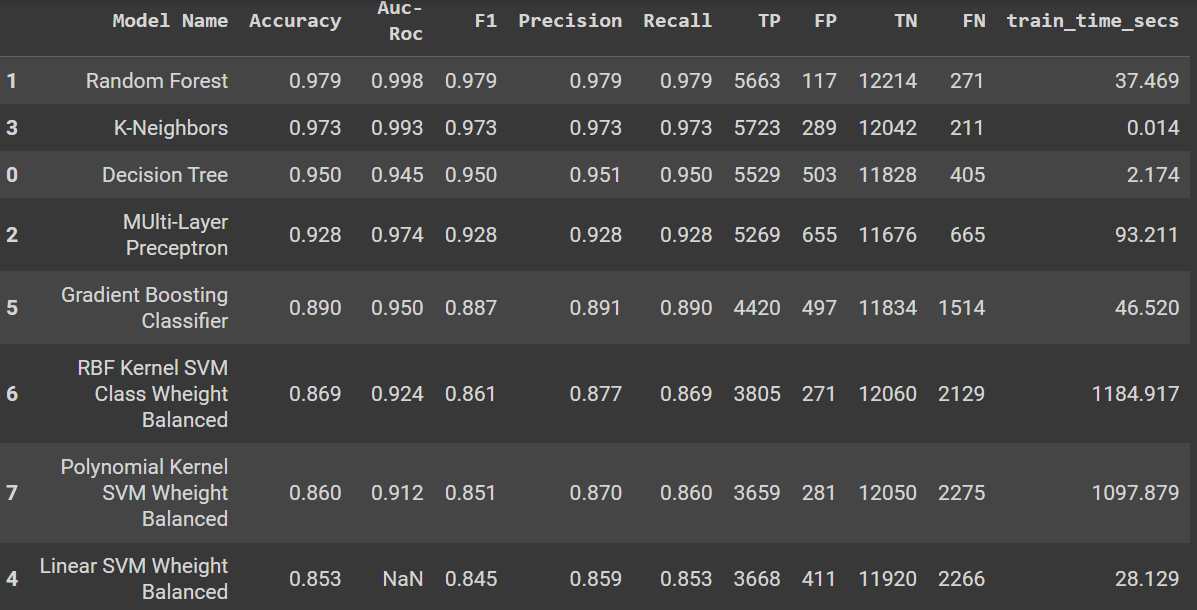

# Visualisations

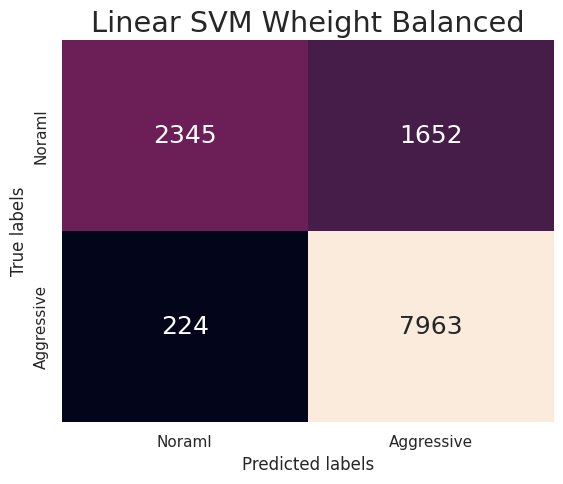

In [18]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(models_dict, X_test, y_test):
    # Number of models
    num_models = len(models_dict)
    num_rows = (num_models + 2) // 3  # ensure 3 columns, rounding up rows

    # Create a large figure to hold all subplots
    fig, axes = plt.subplots(num_rows, 3, figsize=(16, num_rows * 5))
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    for i, (model_name, model) in enumerate(models_dict.items()):
        try:
          # Predict the outcomes
          # y_pred = model.predict(X_test)
          # Calculate the confusion matrix
          cm = confusion_matrix(y_test, preds_dict[model_name])
          # Plotting the confusion matrix
          sns.heatmap(cm, annot=True, annot_kws={"size": 18}, fmt="d", ax=axes[i],cbar=False)
          axes[i].set_title(model_name,fontsize='xx-large')
          axes[i].set_xlabel('Predicted labels')
          axes[i].set_ylabel('True labels')
          axes[i].xaxis.set_ticklabels(['Noraml', 'Aggressive'],)#rotation=45)
          axes[i].yaxis.set_ticklabels(['Noraml', 'Aggressive'],)#rotation=45)
        except Exception as e:
          print(f"Error in {model_name}: {e}")

    # Adjust the layout and remove any empty subplots
    for j in range(i + 1, num_rows * 3):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(models, X_test, y_test)


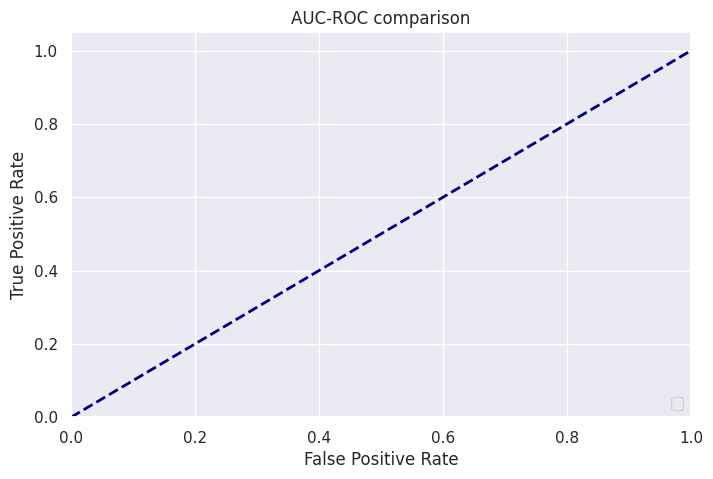

In [19]:
sns.set_theme(style="darkgrid", rc={ 'figure.figsize': (8, 5)})
# Plot summary of ROC Curves
# plt.figure(figsize=(6, 5))
for fpr, tpr, roc_auc, name in roc_data:
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC comparison')
plt.legend(loc="lower right")
plt.show()

# GridSearchCV

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC

# Define the models and parameter grid for each model
models = {
    'LinSVM Weight Balanced': LinearSVC(class_weight=class_weights, max_iter=3000,verbose=True),
    # 'Random Forest': RandomForestClassifier(),
    # 'SVM Class Weight Balanced': SVC(probability=True, class_weight=class_weights,verbose=True),
    # 'Linear SVM Wheight Balanced': LinearSVC(class_weight=class_weights,max_iter=3000),
    # 'Decision Tree': DecisionTreeClassifier(),
    # 'Gradient Boosting Classifier': GradientBoostingClassifier(),
    # 'Logistic Regression': LogisticRegression(),
}

# Define your parameter grids here. This is an example grid.
param_grids = {
    'LinSVM Weight Balanced': {'loss':['hinge','squared_hinge'],
                               'C': [0.1, 1, 10],'tol':[1e4,1e5,1e6,1e7,1e8],},
    # 'Random Forest': {'n_estimators': [10, 50, 100]},
    # 'SVM Class Weight Balanced': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],'kernel':['rbf', 'poly', 'sigmoid']},
    # 'Linear SVM Wheight Balanced': {'C': [0.1, 1, 10]
    # 'Logistic Regression': {'C': [0.1, 1, 10]},
    # 'Decision Tree': {'max_depth': [3, 5, 10]},
    # 'Gradient Boosting Classifier': {'n_estimators': [50, 100, 150]},
}

# Scorer for GridSearch
f1_scorer = make_scorer(f1_score, average='weighted')
# Dictionary to hold evaluation results

results = []
roc_data = []
#  Dictionary to store the best parameters and scores
best_results = {}
# Define the directory path where the model will be saved
directory = f'/content/drive/MyDrive/Models/{time.time()}'
# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Evaluate each model
for name, model in models.items():
    print("Training ",name)
    grid_search = GridSearchCV(model, param_grids[name], scoring=f1_scorer, cv=5,verbose=4,n_jobs=-1)
    start_time = time.time()  # Start timing
    grid_search.fit(X_train_scaled, y_train)  # Assume X_train, y_train are your data
    best_estimator = grid_search.best_estimator_

    end_time = time.time()  # End timing
    training_time = round(end_time - start_time,3)  # Calculate training time
    print(f"Done after {training_time:.2f} seconds")
    best_results[name] = {
        'Best Parameters': grid_search.best_params_,
        # 'Best F1 Score': grid_search.best_score_
    }

    # print("Training ",name)
    # start_time = time.time()  # Start timing
    # model.fit(X_train_scaled, y_train)  # Train the model
    # end_time = time.time()  # End timing
    # training_time = round(end_time - start_time,3)  # Calculate training time
    # print(f"Done after {training_time:.2f} seconds")

    # Save the model to the newly created directory
    model_path = os.path.join(directory, f'{model}.pkl')
    # Save the model to a file
    joblib.dump(model, model_path)

    y_pred = best_estimator.predict(X_test_scaled)
    y_prob = best_estimator.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else None # hasattr is something new I learned in this project!
    preds_dict[name] = y_pred

    # Evaluate the model
    acc = round(accuracy_score(y_test, y_pred),3)
    auc_score = round(roc_auc_score(y_test, y_prob[:, 1]),3) if y_prob is not None else None
    f1 = round(f1_score(y_test, y_pred, average='weighted'),3)
    precision = round(precision_score(y_test, y_pred, average='weighted'),3)
    recall = round(recall_score(y_test, y_pred, average='weighted'),3)
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

    # Store results
    results.append({
        'Model Name': name,'Accuracy': acc,'Auc-Roc': auc_score,'F1': f1,
        'Precision': precision,'Recall': recall,'TP': tp,'FP': fp,'TN': tn,'FN': fn,
        'train_time_secs': training_time})
    bot.send_message(chat_id,f'{best_results}')

    # Store data for summary ROC plot
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_data.append((fpr, tpr, roc_auc, name))

# Create DataFrame from results
results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
bot.send_message(chat_id, 'Code finished running Master.')

# Display the DataFrame
display(results_df)

# Run GridSearchCV for each model
# for name, model in models.items():

# Display or return the results


Training  LinSVM Weight Balanced
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LibLinear]Done after 10.45 seconds


Model Name  Accuracy Auc-Roc     F1  Precision  Recall    TP  \
0  LinSVM Weight Balanced     0.783    None  0.749      0.819   0.783  1452   

   FP    TN    FN  train_time_secs  
0  96  8091  2545           10.452

In [21]:
grid_search.best_params_

{'C': 0.1, 'loss': 'hinge', 'tol': 100000000.0}

___

# OLD

## Fitting SVM Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train the SVM classifier
svm_classifier = SVC(kernel='rbf')  # You can adjust the parameters as needed
svm_classifier.fit(X_train_scaled, y_train)

# Predict on the testing set
y_pred = svm_classifier.predict(X_test_scaled)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
# prompt: plot confusion matrix

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for SVM Classifier")
plt.show()

## Fitting a Random Forrest

In [ ]:
# prompt: using X_train, X_test, y_train,y_text, fit a random forrest classifier

import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Instantiate the Random Forest classifier
random_forest_classifier = RandomForestClassifier()

# Fit the classifier on the training data
random_forest_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = random_forest_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy (Random Forest):", accuracy_score(y_test, y_pred_rf))
print("Classification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))

# Generate the confusion matrix for Random Forest
cf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted (Random Forest)")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()


## Fitting XGBoost

In [ ]:
# prompt: using X_train, X_test, y_train,y_text, fit a XGBoost classifier

import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier

# Instantiate the XGBClassifier
xgb_classifier = XGBClassifier()

# Fit the classifier on the training data
xgb_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_xgb = xgb_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy (XGBoost):", accuracy_score(y_test, y_pred_xgb))
print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))

# Generate the confusion matrix for XGBoost
cf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix for XGBoost
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted (XGBoost)")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGBoost Classifier")
plt.show()


In [ ]:
# prompt: create a data frame of results and a function to add results for every model. columns: model_name, data_set, accuracy,f1,precission,recall

import pandas as pd
# Create a DataFrame to store results
results_df = pd.DataFrame(columns=["model_name", "data_set", "accuracy", "f1", "precision", "recall"])

def add_results(results_df,model_name, data_set, accuracy, f1, precision, recall):
  """
  Adds a new row to the results DataFrame with the provided metrics.

  Args:
    model_name: The name of the model.
    data_set: The name of the dataset.
    accuracy: The accuracy score.
    f1: The F1 score.
    precision: The precision score.
    recall: The recall score.
  """

  new_row = {
      "model_name": model_name,
      "data_set": data_set,
      "accuracy": accuracy,
      "f1": f1,
      "precision": precision,
      "recall": recall
  }
  results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

# Add results for each model
add_results(results_df,"SVM", "Test", accuracy_score(y_test, y_pred),
           classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"],
           classification_report(y_test, y_pred, output_dict=True)["1"]["precision"],
           classification_report(y_test, y_pred, output_dict=True)["1"]["recall"])

add_results(results_df,"Random Forest", "Test", accuracy_score(y_test, y_pred_rf),
           classification_report(y_test, y_pred_rf, output_dict=True)["1"]["f1-score"],
           classification_report(y_test, y_pred_rf, output_dict=True)["1"]["precision"],
           classification_report(y_test, y_pred_rf, output_dict=True)["1"]["recall"])

add_results(results_df,"XGBoost", "Test", accuracy_score(y_test, y_pred_xgb),
           classification_report(y_test, y_pred_xgb, output_dict=True)["1"]["f1-score"],
           classification_report(y_test, y_pred_xgb, output_dict=True)["1"]["precision"],
           classification_report(y_test, y_pred_xgb, output_dict=True)["1"]["recall"])

# Print the DataFrame
display(results_df)


## Hyper-Parameters

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

def process_data(raw_train, raw_test, min_t, max_t):
    # Assuming sliding_window_features_optimized is already defined and imported
    train_processed = sliding_window_features_optimized(raw_train, min_t=min_t, max_t=max_t, step=1)
    test_processed = sliding_window_features_optimized(raw_test, min_t=min_t, max_t=max_t, step=1)

    X_train = train_processed.drop('label', axis=1)
    y_train = train_processed['label']
    X_test = test_processed.drop('label', axis=1)
    y_test = test_processed['label']

    return X_train, X_test, y_train, y_test

def train_evaluate_svm(X_train, X_test, y_train, y_test, kernel='rbf', C=1.0, gamma='scale'):
    # Pipeline for scaling and SVM classification
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel=kernel, C=C, gamma=gamma))
    ])

    # Train the pipeline
    pipeline.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = pipeline.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

# Set parameter range
param_grid = {
    'min_t': np.arange(2, 16),
    'max_t': np.arange(2, 16),
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1],
    'svm__kernel': ['rbf']
}

# Since GridSearchCV requires a single estimator, create a wrapper that accepts raw data and all params
def svm_grid_search(raw_train, raw_test, param_grid):
    best_score = 0
    best_params = None
    best_report = None

    for min_t in param_grid['min_t']:
        for max_t in param_grid['max_t']:
            if max_t >= min_t:  # Ensure max_t is not less than min_t
                X_train, X_test, y_train, y_test = process_data(raw_train, raw_test, min_t, max_t)
                for C in param_grid['svm__C']:
                    for gamma in param_grid['svm__gamma']:
                        for kernel in param_grid['svm__kernel']:
                            accuracy, report = train_evaluate_svm(X_train, X_test, y_train, y_test, kernel, C, gamma)
                            if accuracy > best_score:
                                best_score = accuracy
                                best_params = {'min_t': min_t, 'max_t': max_t, 'C': C, 'gamma': gamma, 'kernel': kernel}
                                best_report = report

    print("Best Score:", best_score)
    print("Best Params:", best_params)
    print("Classification Report:\n", best_report)

# Example usage:
# raw_train, raw_test = load_your_data()  # You need to load or define your raw_train and raw_test datasets
svm_grid_search(raw_train, raw_test, param_grid)


In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Assuming sliding_window_features_optimized is already defined
# If not, you'll need to define this function based on your dataset's needs

def preprocess_data(raw_data, min_t, max_t):
    processed_data = sliding_window_features_optimized(raw_data, min_t=min_t, max_t=max_t, step=1)
    X = processed_data.drop('label', axis=1)
    y = processed_data['label']
    return X, y

# Define the model and pipeline
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

# Define the parameter grid
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.01, 0.1, 1],
    # Add the custom function parameters
    'preprocess__min_t': np.arange(2, 16),
    'preprocess__max_t': np.arange(2, 16)
}

# Custom transformer to handle the preprocessing within the pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, min_t=2, max_t=15):
        self.min_t = min_t
        self.max_t = max_t

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return preprocess_data(X, self.min_t, self.max_t)

# Update the pipeline with the custom preprocessor
pipe.steps.insert(0, ('preprocess', CustomPreprocessor()))

# Initialize GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', verbose=2)

# Split your dataset (assuming raw_train and raw_test are defined)
# X_train, y_train = preprocess_data(raw_train, 2, 15)
# X_test, y_test = preprocess_data(raw_test, 2, 15)

# Now fit using the raw data directly
grid_search.fit(raw_train, raw_train['label'])  # Here raw_train should be the full DataFrame including labels


# Evaluation using raw_test (assuming raw_test is also a full DataFrame including labels)
y_pred = grid_search.predict(raw_test.drop('label', axis=1))
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(raw_test['label'], y_pred))
print("Classification Report:\n", classification_report(raw_test['label'], y_pred))

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


In [ ]:
# Assuming raw_train is your raw training data and it has the 'label' column
# Split raw_train into training and validation if not split previously
# X_train, X_test, y_train, y_test = train_test_split(raw_train.drop('label', axis=1), raw_train['label'], test_size=0.2, random_state=42)

# Initialize GridSearchCV with the pipeline and the parameter grid
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', verbose=2)

# Now fit using the raw data directly
grid_search.fit(raw_train, raw_train['label'])  # Here raw_train should be the full DataFrame including labels

# Evaluation using raw_test (assuming raw_test is also a full DataFrame including labels)
y_pred = grid_search.predict(raw_test.drop('label', axis=1))
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(raw_test['label'], y_pred))
print("Classification Report:\n", classification_report(raw_test['label'], y_pred))


In [ ]:
from sklearn.neural_network import MLPClassifier

mlpc=MLPClassifier()
mlpc.fit(X_train,y_train)
y_pred=mlpc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


## Step 1: Loading and Understanding the Sensor Data



- **Accelerometer**: Measures acceleration including gravity. Once gravitational acceleration is removed, the remaining signal can indicate tilt relative to gravity when the device is not undergoing linear motion.
- **Gyroscope**: Measures the rate of rotation around each axis in degrees per second.
- **timestamp**:
- **label**:


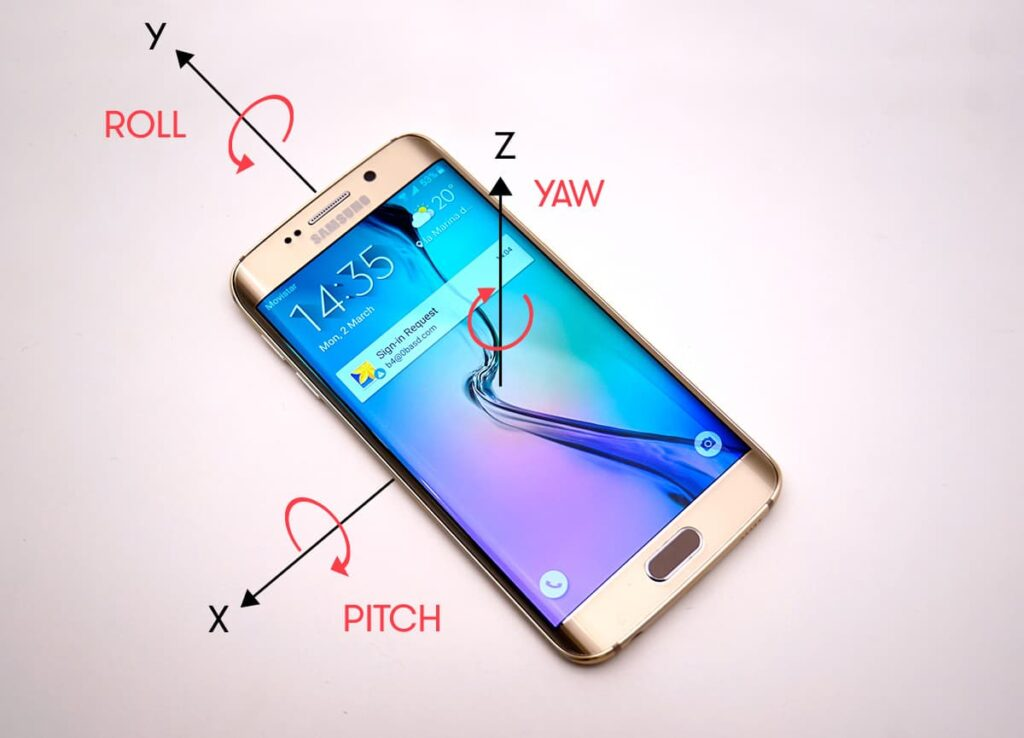

In [ ]:

train_path = 'https://raw.githubusercontent.com/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/main/data/Driving%20Behavior%20Kaggle%20Data%20Set/train_motion_data.csv'
train_raw = pd.read_csv(train_path)
favorite_col_names = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'label','timestamp']
train_raw.columns = favorite_col_names
train_raw.info()
train_raw.head()

In [ ]:
train_raw[['timestamp']].describe()

In [ ]:
train_raw[['timestamp']].plot(figsize=(12, 4))


In [ ]:
# @title label vs acc_x

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(train_raw['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train_raw, x='acc_x', y='label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# @title label vs acc_z

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(train_raw['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train_raw, x='acc_z', y='label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)


## Step 2: Setting up the Environment



Let's assume you have a pandas DataFrame called `data` with columns `accel_x`, `accel_y`, `accel_z`, `gyro_x`, `gyro_y`, `gyro_z`, `label`, and `timestamp`. First, you'll need to convert gyroscope data from degrees per second to radians per second because mathematical functions in most programming environments use radians.


![Demonstration of roll, pitch and azimuth](https://github.com/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/blob/main/visuals/Demonstration-of-roll-pitch-and-azimuth.png?raw=true)


Source:
GOPA: Geometrical Optics Positioning Algorithm Using Spatial Color Coded LEDs (Extended Version) - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Demonstration-of-roll-pitch-and-azimuth_fig1_326476858 [accessed 28 Apr, 2024]




## Feature Extraction
To approximate the orientation of a mobile device using accelerometer and gyroscope data, one common method is to use [sensor fusion techniques](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9824767/). These often involve the use of complementary filters or more sophisticated approaches like Kalman filters, which blend the accelerometer and gyroscope readings to estimate the device's orientation with respect to gravity (pitch and roll angles). Here, I'll provide a simplified version using a complementary filter because it's relatively straightforward to implement.


In [ ]:
import pandas as pd
import numpy as np
data = train_raw
# Example DataFrame setup (to be replaced with actual data loading)
# data = pd.read_csv('your_dataset.csv')

# Convert gyroscope data from degrees to radians
data['gyro_x'] *= np.pi / 180
data['gyro_y'] *= np.pi / 180
data['gyro_z'] *= np.pi / 180



**Pitch**: This is the angle that represents rotation around the lateral or y-axis. Imagine tilting your head up and down — that's similar to the pitch motion. In terms of a smartphone, it indicates how much the top or bottom of the device is tilted towards or away from you.

The pitch angle is calculated using the \(y\)-axis and \(z\)-axis accelerometer readings:
$\text{pitch} = \arctan\left(\frac{accel\_y}{\sqrt{accel\_x^2 + accel\_z^2}}\right)$

**Roll**: This is the angle around the longitudinal or x-axis. Think of it as tilting your head toward your shoulders. For a smartphone, it describes how much the device is tilted side-to-side.

The roll angle is calculated using the \(x\)-axis and \(z\)-axis accelerometer readings:
$\text{roll} = \arctan\left(\frac{-accel\_x}{\sqrt{accel\_y^2 + accel\_z^2}}\right)$



### Complementary Filter
The complementary filter combines the gyroscope data (integrated over time to get an angle) and the accelerometer data (to correct the drift in gyroscope data) for both pitch and roll. Here's the general formula used:


$$\text{angle} = \alpha (\text{angle}_{\text{prev}} + \text{gyro_data} \times \text{dt}) + (1 - \alpha) \times \text{acceleration} $$

Where:
- $\text{angle}_{prev}$ is the angle estimated in the previous time step.
- $gyro$ is the gyroscope reading for the respective axis.
- $dt$ is the time interval between readings.
- `$acceleration$ is the angle calculated from accelerometer data.
- $\alpha$ is a constant that determines the balance between the gyroscope and accelerometer readings, often set around 0.98.




In [ ]:
print(data.shape)
# Initialize columns for estimated angles
data['pitch'] = 0
data['roll'] = 0

# Time step (delta t)
dt = 0.5  # since the sampling rate is 2 samples per second

# Filter constant
alpha = 0.98

for i in range(1, len(data)):
    # Gyroscope integration to estimate angles
    data.loc[i, 'pitch'] = data.loc[i-1, 'pitch'] + data.loc[i, 'gyro_x'] * dt
    data.loc[i, 'roll'] = data.loc[i-1, 'roll'] + data.loc[i, 'gyro_y'] * dt

    # Accelerometer readings to correct drift
    accel_pitch = np.arctan2(data.loc[i, 'acc_y'], data.loc[i, 'acc_z'])
    accel_roll = np.arctan2(-data.loc[i, 'acc_x'], np.sqrt(data.loc[i, 'acc_y']**2 +
                                                           data.loc[i, 'acc_z']**2))

    # Complementary filter to blend the outputs
    data.loc[i, 'pitch'] = alpha * data.loc[i, 'pitch'] + (1 - alpha) * accel_pitch
    data.loc[i, 'roll'] = alpha * data.loc[i, 'roll'] + (1 - alpha) * accel_roll

print(data.shape)


In [ ]:
data['label'] = data['label'].replace({'SLOW'       : -1,
                                       'NORMAL'     : 0,
                                       'AGGRESSIVE' : 1})



### Step 4: Using the Data
The columns `pitch` and `roll` in your DataFrame now contain the estimated orientations of the device in radians. You can convert these to degrees, plot them, or use them as features in further analysis or modeling.

**Note**: For more precise applications, especially when precise orientation tracking is crucial, you might consider using a *Kalman filter* or other advanced sensor fusion algorithms, which can dynamically adjust the filter parameters based on the noise characteristics of the sensors.

In [ ]:
# prompt: import train_test_split  and StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [ ]:
aggressive_df = data[data['label'] == 1].copy()

# plot line


In [ ]:
def preprocess_inputs(df):
    df = df.copy()
    df['timestamp'] = df['timestamp']/60

    y = df['label']
    X = df.drop('label',axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3, shuffle=True, random_state=43)

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns, index=X_test.index)

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = preprocess_inputs(data)
X_train


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import LinearSVC, SVC


In [ ]:
# prompt: import  GradientBoostingClassifier(),,BaggingClassifier(),LinearSVC(), SVC()

from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import LinearSVC, SVC

# Create the models
gb = GradientBoostingClassifier()
bagging = BaggingClassifier()
linear_svc = LinearSVC()
svc = SVC()

# Store the models in a dictionary
models = {
    "Gradient Boosting": gb,
    "Bagging": bagging,
    "Linear SVC": linear_svc,
    "SVC": svc,
}


In [ ]:
models = {
    '        Logistic Regression' : LogisticRegression(),
    '              Decision Tree' : DecisionTreeClassifier(),
    '              Random Forest' : RandomForestClassifier(),
    '             MUlti-Layer Preceptron' : MLPClassifier(),
    '                 K-Neighbors': KNeighborsClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    '          Bagging Classifier': BaggingClassifier(),
    '                  Linear SVM': LinearSVC(),
    '                  Kernel SVM': SVC()
}

for name, model in models.items():
    model = model.fit(X_train,y_train)
    print(name + " trained")

In [ ]:
for name, model in models.items():
    print(name + ": {:.2f}%".format(model.score(X_test, y_test) * 100))

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/petroniocandido/DriverBehaviorClassificationDatasets/main/Data/junior_2019/dataset.csv')
df.info()

In [ ]:

# Convert the 'timestamp' column to datetime
df['timestamp_raw'] = df['timestamp'].copy()

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Option 1: Extract year, month, day, hour, minute, and second
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['second'] = df['timestamp'].dt.second

# Option 2: Convert to POSIX timestamp
df['posix_timestamp'] = df['timestamp'].astype(int) / 1e9  # Convert to seconds

df['sample'].value_counts()

In [ ]:
df[['aclnx', 'aclny','']]

In [ ]:
import pandas as pd

In [ ]:
path = "https://raw.githubusercontent.com/QinHsiu/Driver-Behaviour-Identification/main/Original%20Data/Original%20Data/861193041083735-1629249913.0-BRAKE.csv"
df = pd.read_csv(path)
df.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)
df.head()

In [ ]:
# prompt: Using dataframe df: line plot of acc_x,acc_y,acc_z vs timestamp with matplotlib

import matplotlib.pyplot as plt

# Plot the data
plt.plot(df['timestamp'], df['acc_x'], label='acc_x')
plt.plot(df['timestamp'], df['acc_y'], label='acc_y')
plt.plot(df['timestamp'], df['acc_z'], label='acc_z')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
path2= 'https://raw.githubusercontent.com/QinHsiu/Driver-Behaviour-Identification/main/Original%20Data/Original%20Data/863293055538448-1625179321.0-BRAKE.csv'
df = pd.read_csv(path2)
df.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)
df.head()

In [ ]:
# prompt: Using dataframe df: line plot of acc_x,acc_y,acc_z vs timestamp with matplotlib

import matplotlib.pyplot as plt

# Plot the data
plt.plot(df['timestamp'], df['acc_x'], label='acc_x')
plt.plot(df['timestamp'], df['acc_y'], label='acc_y')
plt.plot(df['timestamp'], df['acc_z'], label='acc_z')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
path3 = "https://raw.githubusercontent.com/petroniocandido/DriverBehaviorClassificationDatasets/main/Data/yuksel_2020/dataset.csv"
df = pd.read_csv(path3)
df.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)
df.head()
df.info()

In [ ]:
df['Class'].value_counts()

In [ ]:
# loading nazirkar_2021 data set
path4 ='https://raw.githubusercontent.com/petroniocandido/DriverBehaviorClassificationDatasets/main/Data/nazirkar_2021/dataset.csv'
df = pd.read_csv(path4)
df.columns = df.columns.str.lower()

df.info()
df.head()

## EDA

In [ ]:
# # prompt: Using dataframe merged_df: plot each colunn against the index

# for column in merged_df.columns:
#     merged_df.plot(y=column);


In [ ]:
# # Group the DataFrame by the 'label' column
# grouped_df = merged_df[[ 'Time', 'Acc X', 'Acc Y','Acc Z', 'Heading', 'gyro_x', 'gyro_y', 'gyro_z', 'label']].groupby('label')

# # Calculate descriptive statistics for each group
# descriptive_stats = grouped_df.describe()

# # Print the descriptive statistics
# display(descriptive_stats.T)

In [ ]:
# # prompt: use merged_df to make violin plots by label
# import matplotlib.pyplot as plt
# import seaborn as sns
# # Create a violin plot for each numerical column, grouped by label
# for col in ['Acc X', 'Acc Y', 'Acc Z', 'Heading', 'gyro_x', 'gyro_y', 'gyro_z']:
#     sns.violinplot(x='label', y=col, data=merged_df, inner='quartile')
#     plt.title(f'Violin Plot of {col} by Label')
#     plt.xlabel('Label')
#     plt.ylabel(col)
#     plt.show();

In [ ]:
# # prompt: Using dataframe df: Using dataframe df: line plot of accx,accy,accz vs index with matplotlib, fig size (12,14), line width small
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12,14))
# # plt.plot(df.index, df1['accx'], linewidth=0.5, label='accx')
# # plt.plot(df.index, df['accy'], linewidth=0.5, label='accy')
# # plt.plot(df.index, df['accz'], linewidth=0.5, label='accz')
# plt.xlabel('Index')
# plt.ylabel('Acceleration')
# plt.title('Line Plot of accx, accy, accz vs Index')

In [ ]:
# # prompt: Using dataframe df: violin plot plot accx,accy,accz vs class seaborn
# import seaborn as sns
# sns.violinplot(x="class", y="accx", data=df);

In [ ]:
# sns.violinplot(x="class", y="accy", data=df);

In [ ]:
# sns.violinplot(x="class", y="accz", data=df);

## Bootstrap

In [ ]:
# prompt: import classification_report matthews_corrcoef



In [ ]:
models = {
     'RBF Kernel SVM': SVC(kernel='rbf',probability=True),
     'RBF Kernel SVM Class Wheight Balanced': SVC(kernel='rbf',probability=True,class_weight=class_weights),
     'Polynomial Kernel SVM': SVC(kernel='poly',probability=True,),
     'Polynomial Kernel SVM Wheight Balanced': SVC(kernel='poly',probability=True,class_weight=class_weights),
    'Linear SVM': LinearSVC(),
    'Linear SVM Weight Balanced': LinearSVC(class_weight=class_weights),
}

# Dictionary to hold evaluation results
results = []
roc_data = []
for name, model in models.items():
    print("Training ",name)
    start_time = time.time()  # Start timing
    model.fit(X_train_scaled, y_train)
    end_time = time.time()  # End timing
    training_time = round(end_time - start_time,3)  # Calculate training time
    print(f"Training took {training_time:.2f} seconds")
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else None

    print(f"Accuracy for {name}:", accuracy_score(y_test, y_pred))
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob[:, 1]) if y_prob is not None else None
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)  # Calculate MCC
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()
    # Store results
    results.append({
        'Model Name': name,'Accuracy': acc,'Auc-Roc': auc_score,'F1': f1,
        'Precision': precision,'Recall': recall,'MCC': mcc,  # Include MCC in the results
        'TP': tp,'FP': fp,'TN': tn,'FN': fn,
        'runtime_sec': training_time})

# Create DataFrame from results
results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)

# Display the DataFrame
display(results_df)

In [ ]:
bot.send_message(chat_id, 'Code finished running Master.')


In [ ]:
from sklearn.utils import resample
from scipy import stats
from sklearn.metrics import matthews_corrcoef

# Find the model with the highest accuracy
best_model_name = results_df.loc[results_df['F1'].idxmax()]['Model Name']
best_model = models[best_model_name]

bootstrap_accuracies = []
bootstrap_mccs = []  # Will store MCC of each sub-sample

# Number of bootstrap samples to create
n_bootstrap = 25  # Consider reducing this number if running time is too long

# Create bootstrap samples and calculate accuracy and MCC for each of them
for i in range(n_bootstrap):
    X_train_resampled, y_train_resampled = resample(X_train_scaled, y_train)

    # Train the best SVM classifier on the resampled data
    best_model.fit(X_train_resampled, y_train_resampled)

    # Predict on the testing set
    y_pred_resampled = best_model.predict(X_test_scaled)

    # Calculate accuracy and append to the list
    bootstrap_accuracies.append(accuracy_score(y_test, y_pred_resampled))

    # Calculate MCC and append to the list
    mcc = matthews_corrcoef(y_test, y_pred_resampled)
    bootstrap_mccs.append(mcc)

# Calculate the mean accuracy and MCC from the bootstrap samples
mean_accuracy = np.mean(bootstrap_accuracies)
mean_mcc = np.mean(bootstrap_mccs)

# Calculate the standard error
standard_error_accuracy = np.std(bootstrap_accuracies)
standard_error_mcc = np.std(bootstrap_mccs)

# Calculate the p-value
t_statistic_accuracy, p_value_accuracy = stats.ttest_1samp(bootstrap_accuracies, mean_accuracy)
t_statistic_mcc, p_value_mcc = stats.ttest_1samp(bootstrap_mccs, mean_mcc)

print(f"Mean bootstrap accuracy: {mean_accuracy}")
print(f"Standard error of accuracy: {standard_error_accuracy}")
print(f"P-value of accuracy: {p_value_accuracy:.10f}")

print(f"Mean bootstrap MCC: {mean_mcc}")
print(f"Standard error of MCC: {standard_error_mcc}")
print(f"P-value of MCC: {p_value_mcc:.10f}")

# Check the significance
if p_value_accuracy < 0.05:
    print("The difference in accuracy is statistically significant.")
else:
    print("The difference in accuracy is not statistically significant.")

if p_value_mcc < 0.05:
    print("The difference in MCC is statistically significant.")
else:
    print("The difference in MCC is not statistically significant.")

# Plot histogram of bootstrap accuracies
plt.hist(bootstrap_accuracies, bins=10, edgecolor='black')
plt.title('Bootstrap Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

# Plot histogram of bootstrap MCCs
plt.hist(bootstrap_mccs, bins=10, edgecolor='black')
plt.title('Bootstrap MCCs')
plt.xlabel('MCC')
plt.ylabel('Frequency')
plt.show()